# Assembly of Primitive hierarchies (representing molecular structures) from MuPT core components from the ground up
Here we see how to assemble a non-trivial molecular structure, with correct topology AND reasonable positions, using pure MuPT representation components
The demonstration here is for a polyphenylene-sulfone middle repeat unit fragment, but it should become clear that the approaches for other systems vary little   

This is definitely **not** intended or recommended as a tutorial for assembling repeat units for large, complex systems; if that's all you need, just use e.g. primitive_from_smiles()  
Rather, this demo is intended to illustrate how all the components of the MuPT representation fit together and how information is organized w/in the representational hierarchy

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation, RigidTransform

from mupt.chemistry.core import ELEMENTS, BondType
from mupt.geometry.shapes import PointCloud
from mupt.mupr.primitives import Primitive, PrimitiveHandle
from mupt.mupr.connection import Connector, ConnectorHandle, AttachmentPoint, TraversalDirection

In [2]:
# common values references throughout construction
traversal_pair : tuple[TraversalDirection, TraversalDirection] = (TraversalDirection.ANTERO, TraversalDirection.RETRO)

center_pos = np.array([0, 0, 0], dtype=float)
axis_pos   = np.array([1, 0, 0], dtype=float)
corner_pos = np.array([1, 1, 1], dtype=float)

## Avenue 2) hierarchical assembly from chemically-meaningful subunits
More involved conceptually, but reuses information as much as possible and illustrates the flexibility of the representation

## Define p-phenyl group

In [3]:
# define connector types which feature in a phenyl ring
arene_ring_conn = Connector(
    anchor=AttachmentPoint({'c'}, position=center_pos),
    linker=AttachmentPoint({'c'}, position=axis_pos),
    bondtype=BondType.AROMATIC,
    label='arene_ring_bond',
)
arene_substituent_master_conn = Connector(
    anchor=AttachmentPoint({'c'}, position=center_pos),
    linker=AttachmentPoint({'H', 'S', 'O', '*'}, position=axis_pos),
    bondtype=BondType.SINGLE,
    label='arene_substituent_bond',
)
arene_substituent_conns : dict[tuple[str, str], Connector] = arene_substituent_master_conn.individualize()

In [4]:
# define arene carbon
arene_carbon = Primitive(
    shape=PointCloud(center_pos),
    element=ELEMENTS[6],
    label='aryl_carbon'
)
c_subst_handle  : ConnectorHandle = arene_carbon.register_connector(arene_substituent_master_conn.copy())
cc_ring_handle1 : ConnectorHandle = arene_carbon.register_connector(arene_ring_conn.copy())
cc_ring_handle2 : ConnectorHandle = arene_carbon.register_connector(arene_ring_conn.copy())

## move Connectors into triangular planar config around center
for conn, rot in zip(arene_carbon.connectors.values(), Rotation.create_group('C3'), strict=True):
    conn.rigidly_transform(RigidTransform.from_rotation(rot))

In [5]:
# define arene hydrogen
Hc_conn : Connector = arene_carbon.connectors[c_subst_handle].counterpart()
Hc_conn.anchor.attachables = {'H'} # specialize anchor attachment designation to hydrogen-only

arene_hydrogen = Primitive(
    shape=PointCloud(Hc_conn.anchor.position),
    element=ELEMENTS[1],
    label='aryl_hydrogen'
)
H_subst_handle : ConnectorHandle = arene_hydrogen.register_connector(Hc_conn)

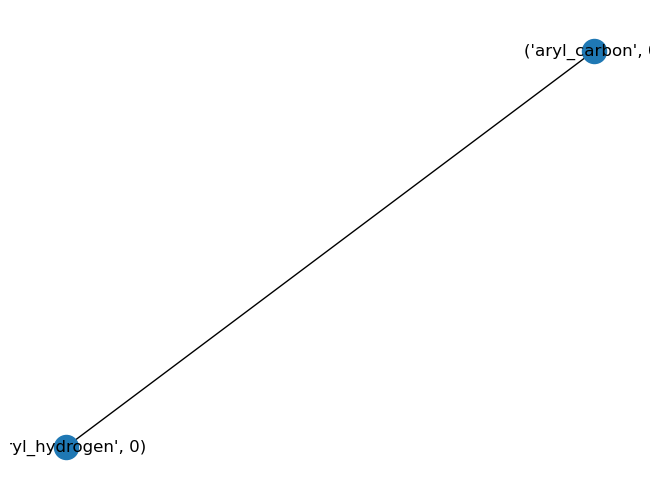

In [6]:
# define c-H unit appearing along arene ring
arene_CH = Primitive(label='arene_CH')
c_handle : PrimitiveHandle = arene_CH.attach_child(arene_carbon)
H_handle : PrimitiveHandle = arene_CH.attach_child(arene_hydrogen)
arene_CH.connect_children(
    c_handle, c_subst_handle,
    H_handle, H_subst_handle,
)
arene_CH.visualize_topology()

In [7]:
# assemble phenyl ring
from itertools import cycle
from mupt.mutils.iteration import sliding_window


paraphenyl = Primitive(label='paraphenyl')
ring_members : tuple[Primitive] = (
    arene_carbon.copy(),
    arene_CH.copy(),
    arene_CH.copy(),
    arene_carbon.copy(),
    arene_CH.copy(),
    arene_CH.copy(),
)
# place children along hexagon vertices on circumcircle of given size
radius : float = 1.1
for ring_member_prim, rot in zip(ring_members, Rotation.create_group('C6')):
    transform = RigidTransform.from_rotation(rot) * RigidTransform.from_translation([radius, 0, 0])
    ring_member_prim.rigidly_transform(transform)
    ring_member_handle : PrimitiveHandle = paraphenyl.attach_child(ring_member_prim)
    
# adjust bond lengths and connect carbons along ring
for c1_handle, c2_handle in sliding_window(cycle(paraphenyl.children_by_handle), n=2):
    if paraphenyl.internal_connection_between(c1_handle, c2_handle):
        break # exit once wrapped all the way around ring
    
    paraphenyl.connect_children(
        c1_handle, cc_ring_handle1,
        c2_handle, cc_ring_handle2,
    )
    Connector.mutually_antialign_ballistically(
        paraphenyl.fetch_connector_on_child(c1_handle, cc_ring_handle1),
        paraphenyl.fetch_connector_on_child(c2_handle, cc_ring_handle2),
    )

paraphenyl
├── aryl_carbon
├── arene_CH
│   ├── aryl_carbon
│   └── aryl_hydrogen
├── arene_CH
│   ├── aryl_carbon
│   └── aryl_hydrogen
├── aryl_carbon
├── arene_CH
│   ├── aryl_carbon
│   └── aryl_hydrogen
└── arene_CH
    ├── aryl_carbon
    └── aryl_hydrogen
('arene_substituent_bond', 0) Connector(anchor=AttachmentPoint(attachables={<TraversalDirection.ANTERO: 1>, 'c'}, attachment=None, position=array([1.1, 0. , 0. ])), linker=AttachmentPoint(attachables={'H', <TraversalDirection.RETRO: 2>}, attachment=None, position=array([2.1, 0. , 0. ])), bondtype=rdkit.Chem.rdchem.BondType.SINGLE, bond_length=np.float64(1.0), label='arene_substituent_bond', dihedral_plane_set=False)
('arene_substituent_bond', 1) Connector(anchor=AttachmentPoint(attachables={<TraversalDirection.RETRO: 2>, 'c'}, attachment=None, position=array([-1.10000000e+00,  1.34711148e-16,  0.00000000e+00])), linker=AttachmentPoint(attachables={'H', <TraversalDirection.ANTERO: 1>}, attachment=None, position=array([-2.1000000

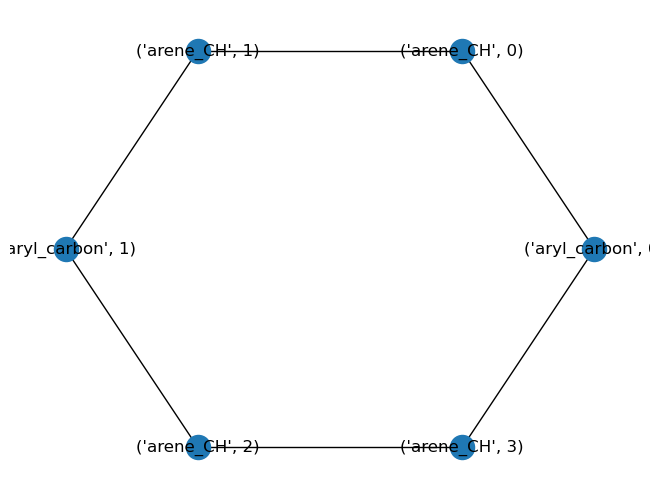

In [8]:
print(paraphenyl.hierarchy_summary())
paraphenyl.visualize_topology()
for (conn_handle, conn), traver_dir in zip(paraphenyl.connectors.items(), traversal_pair):
    conn.anchor.attachables.add(traver_dir)
    conn.linker.attachables.add(TraversalDirection.complement(traver_dir))
    print(conn_handle, conn)

## Define sulfone group

In [9]:
# define connector types which feature in a sulfone group
sulfoxy_conn = Connector(
    anchor=AttachmentPoint({'S'}, position=center_pos),
    linker=AttachmentPoint({'O'}, position=corner_pos),
    bondtype=BondType.DOUBLE,
    label='sulfoxy_bond',
)
sulfoxy_conn.set_bond_length(1.3)
thio_conn = Connector(
    anchor=AttachmentPoint({'S'}, position=center_pos),
    linker=AttachmentPoint({'c'}, position=corner_pos), # alternating cube corners, to match eventual orientation with tetrahedral group
    bondtype=BondType.SINGLE,
    label='thio_bond',
)
thio_conn.set_bond_length(1.2)

In [10]:
# define center sulfur of sulfone
sulfone_S = Primitive(
    shape=PointCloud(positions=center_pos),
    element=ELEMENTS[16],
    label='S',
)
SO_conn_handle1 : ConnectorHandle = sulfone_S.register_connector(sulfoxy_conn.copy())
SO_conn_handle2 : ConnectorHandle = sulfone_S.register_connector(sulfoxy_conn.copy())
Sc_conn_handle1 : ConnectorHandle = sulfone_S.register_connector(thio_conn.copy())
Sc_conn_handle2 : ConnectorHandle = sulfone_S.register_connector(thio_conn.copy())

## move Connectors into tetrahedral config around center
for conn, rot in zip(sulfone_S.connectors.values(), Rotation.create_group('T')):
    conn.rigidly_transform(RigidTransform.from_rotation(rot))

In [11]:
# define dangling Oxygen on sulfone 
sulfone_O = Primitive(
    element=ELEMENTS[8],
    label='O'
)
# NOTE: omitting Connector registration here to avoid double-alignment when attaching to center sulfur (will happen below)

In [12]:
# assemble sulfone group
sulfone = Primitive(label='sulfone')

sulfone_S_handle = sulfone.attach_child(sulfone_S.copy())
## attach oxygens to sulfur
for SO_conn_handle in (SO_conn_handle1, SO_conn_handle2):
    sulfone_O_peripheral : Primitive = sulfone_O.copy()
    
    # attach connector to peripheral oxygen which perfectly mirrors (by attachables and position) the tetrahedrally-place sulfur connector
    S_conn : Connector = sulfone.fetch_connector_on_child(sulfone_S_handle, SO_conn_handle)
    OS_conn_handle : ConnectorHandle = sulfone_O_peripheral.register_connector(S_conn.counterpart())
    sulfone_O_peripheral.shape = PointCloud(positions=S_conn.linker.position)
    
    sulfone_O_handle : PrimitiveHandle = sulfone.attach_child(sulfone_O_peripheral)
    sulfone.connect_children(
        sulfone_S_handle, SO_conn_handle,
        sulfone_O_handle, OS_conn_handle,
    )

sulfone
├── S
├── O
└── O
('thio_bond', 0) Connector(anchor=AttachmentPoint(attachables={'S', <TraversalDirection.ANTERO: 1>}, attachment=None, position=array([0., 0., 0.])), linker=AttachmentPoint(attachables={<TraversalDirection.RETRO: 2>, 'c'}, attachment=None, position=array([-0.69282032, -0.69282032,  0.69282032])), bondtype=rdkit.Chem.rdchem.BondType.SINGLE, bond_length=np.float64(1.2000000000000002), label='thio_bond', dihedral_plane_set=False)
('thio_bond', 1) Connector(anchor=AttachmentPoint(attachables={'S', <TraversalDirection.RETRO: 2>}, attachment=None, position=array([0., 0., 0.])), linker=AttachmentPoint(attachables={<TraversalDirection.ANTERO: 1>, 'c'}, attachment=None, position=array([0.69282032, 0.69282032, 0.69282032])), bondtype=rdkit.Chem.rdchem.BondType.SINGLE, bond_length=np.float64(1.2000000000000002), label='thio_bond', dihedral_plane_set=False)


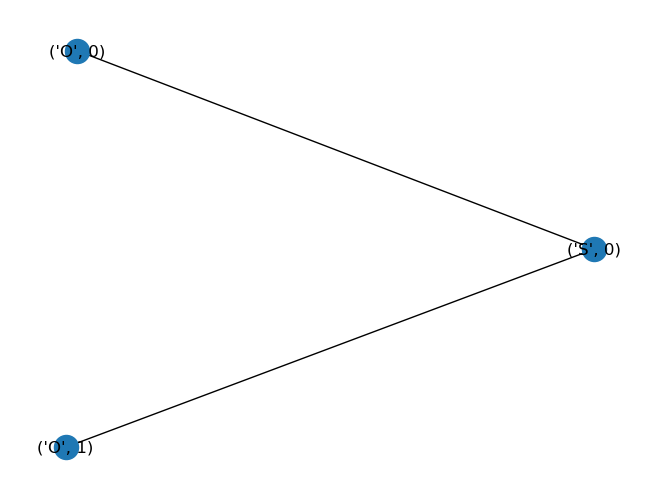

In [13]:
print(sulfone.hierarchy_summary())
sulfone.visualize_topology()
for (conn_handle, conn), traver_dir in zip(sulfone.connectors.items(), traversal_pair):
    conn.anchor.attachables.add(traver_dir)
    conn.linker.attachables.add(TraversalDirection.complement(traver_dir))
    print(conn_handle, conn)

## Define linking oxygen between this and the next repeat unit

In [14]:
mid_oxy_conn : Connector = arene_substituent_conns['c', 'O']#.counterpart()

oxygen = Primitive(
    shape=PointCloud(positions=center_pos),
    element=ELEMENTS[8],
    connectors=[
        mid_oxy_conn.copy(),
        mid_oxy_conn.copy(),
    ],
    label='linking O'
)
# rotate off-oxygen Connectors to be diametrically-opposite and inject traversal direction info
for (conn, rot, traver_dir) in zip(oxygen.connectors.values(), Rotation.create_group('C2'), traversal_pair):
    conn.rigidly_transform(RigidTransform.from_rotation(rot))
    conn.anchor.attachables.add(traver_dir)
    conn.linker.attachables.add(TraversalDirection.complement(traver_dir))

## PPS repeat unit - putting it all together!
With the granular details of the recurring structural motifs (functional groups here) in-place, we can assemble our fragment from those motifs   
at a high-level without getting bogged down in the placement of individual parts or connections; they all get "dragged along for the ride"  

In [15]:
unitprim = Primitive(label='polyphenylene-sulfone_repeat_unit')

# insert functional groups
paraphenyl_handle1 : PrimitiveHandle = unitprim.attach_child(paraphenyl.copy())
sulfone_handle : PrimitiveHandle = unitprim.attach_child(sulfone.copy())
paraphenyl_handle2 : PrimitiveHandle = unitprim.attach_child(paraphenyl.copy())
O_handle : PrimitiveHandle = unitprim.attach_child(oxygen)

In [16]:
# align and bond functional groups
paraphenyl_incoming, paraphenyl_outgoing = paraphenyl.connectors
sulfone_incoming, sulfone_outgoing = sulfone.connectors
oxygen_incoming, oxygen_outgoing = oxygen.connectors

connections : dict[tuple[PrimitiveHandle, ConnectorHandle], tuple[PrimitiveHandle, ConnectorHandle]] = {
    (sulfone_handle, sulfone_incoming) : (paraphenyl_handle1, paraphenyl_outgoing),
    (sulfone_handle, sulfone_outgoing) : (paraphenyl_handle2, paraphenyl_incoming),
    (paraphenyl_handle2, paraphenyl_outgoing) : (O_handle, oxygen_incoming),
}

for (prim_inc_handle, conn_inc_handle), (prim_out_handle, conn_out_handle) in connections.items():
    ## bind internally to complete topology
    unitprim.connect_children(
        prim_inc_handle, conn_inc_handle,
        prim_out_handle, conn_out_handle,
    )
    
    ## rigidly align neighboring functional groups along Connectors to complete spatial alignment
    conn_inc : Connector = unitprim.fetch_connector_on_child(prim_inc_handle, conn_inc_handle)
    conn_out : Connector = unitprim.fetch_connector_on_child(prim_out_handle, conn_out_handle)
    
    prim_out = unitprim.fetch_child(prim_out_handle)
    prim_out.rigidly_transform(conn_out.rigid_antialignment_to(conn_inc))

polyphenylene-sulfone_repeat_unit
├── paraphenyl
│   ├── aryl_carbon
│   ├── arene_CH
│   │   ├── aryl_carbon
│   │   └── aryl_hydrogen
│   ├── arene_CH
│   │   ├── aryl_carbon
│   │   └── aryl_hydrogen
│   ├── aryl_carbon
│   ├── arene_CH
│   │   ├── aryl_carbon
│   │   └── aryl_hydrogen
│   └── arene_CH
│       ├── aryl_carbon
│       └── aryl_hydrogen
├── sulfone
│   ├── S
│   ├── O
│   └── O
├── paraphenyl
│   ├── aryl_carbon
│   ├── arene_CH
│   │   ├── aryl_carbon
│   │   └── aryl_hydrogen
│   ├── arene_CH
│   │   ├── aryl_carbon
│   │   └── aryl_hydrogen
│   ├── aryl_carbon
│   ├── arene_CH
│   │   ├── aryl_carbon
│   │   └── aryl_hydrogen
│   └── arene_CH
│       ├── aryl_carbon
│       └── aryl_hydrogen
└── linking O
('arene_substituent_bond', 0) Connector(anchor=AttachmentPoint(attachables={<TraversalDirection.ANTERO: 1>, 'c'}, attachment=None, position=array([1.1, 0. , 0. ])), linker=AttachmentPoint(attachables={'H', <TraversalDirection.RETRO: 2>}, attachment=None, position=

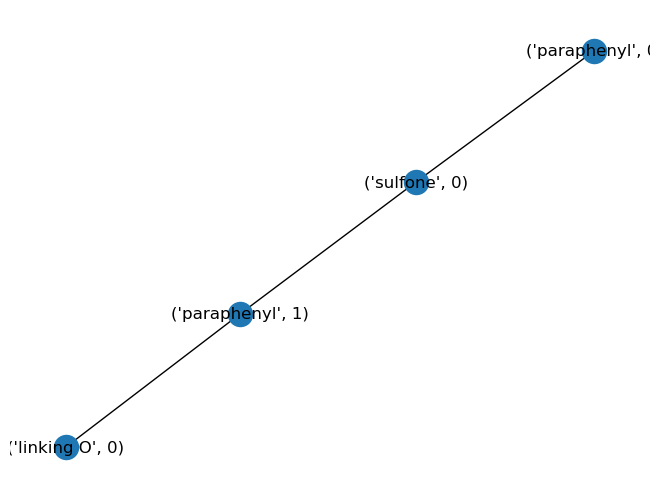

In [17]:
print(unitprim.hierarchy_summary())
unitprim.visualize_topology()
for (conn_handle, conn) in unitprim.connectors.items():
    print(conn_handle, conn)

### Flatten final tree and export to Mol to view results
Flattening brings all leaves of the hierarchy to the first level and reindexes handles to preserve uniqueness of handles  
Observe, for instance, that the handles on the two copies of the phenyl do not conflict

polyphenylene-sulfone_repeat_unit
├── linking O
├── aryl_carbon
├── aryl_carbon
├── aryl_carbon
├── aryl_carbon
├── S
├── O
├── O
├── aryl_carbon
├── aryl_hydrogen
├── aryl_carbon
├── aryl_hydrogen
├── aryl_carbon
├── aryl_hydrogen
├── aryl_carbon
├── aryl_hydrogen
├── aryl_carbon
├── aryl_hydrogen
├── aryl_carbon
├── aryl_hydrogen
├── aryl_carbon
├── aryl_hydrogen
├── aryl_carbon
└── aryl_hydrogen


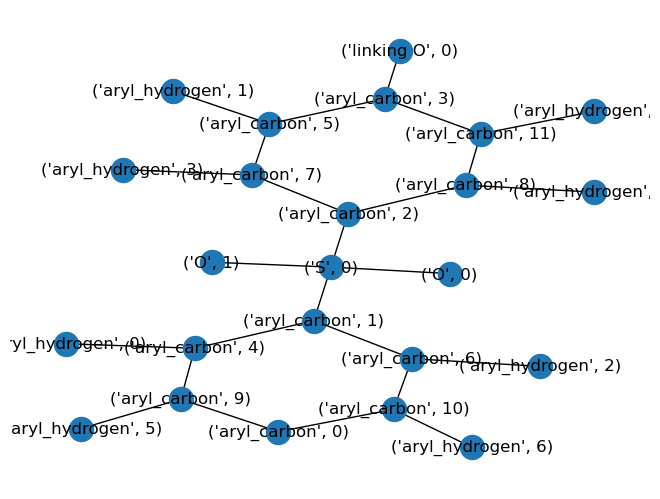

In [18]:
unitprim.flatten()

print(unitprim.hierarchy_summary())
unitprim.visualize_topology()

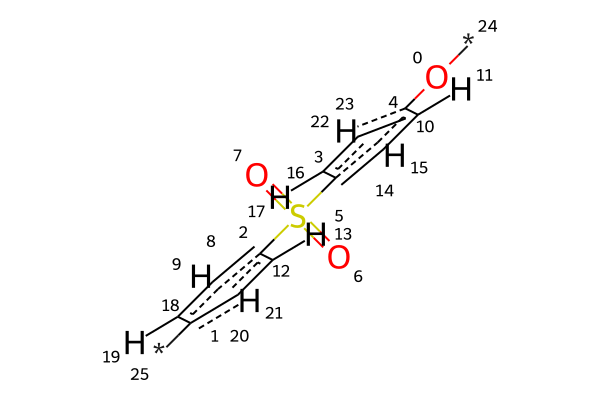

In [19]:
from pathlib import Path
from rdkit.Chem.rdmolfiles import MolToMolFile
from mupt.interfaces.rdkit import primitive_to_rdkit

frag_dir = Path('repr_components')
frag_name : str = 'PPS_unit_from_scratch.mol'

frag_dir.mkdir(exist_ok=True)
frag_path = frag_dir / frag_name

mol = primitive_to_rdkit(unitprim)
display(mol)
MolToMolFile(mol, str(frag_path))

DEV TODOs:
* show even higher level assembly, by connecting a rigidly-transformed copy of unitprim to itself
* show "capping" with -H/-OH to illustrate lateral mixed-resolution compatibility